# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [96]:
import numpy as np
import pandas as pd

import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from binomial import *

In [97]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [98]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

In [99]:
FACE = 100

In [100]:
# fix the rate-tree columns to be float instead of str

rate_tree.columns = [0,0.5]

bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

bond_tree[0.5] = np.exp(-rate_tree[0.5]*0.5)*FACE
bond_tree.iloc[0,0] = term_struct.loc[1,'price']

bond_tree.style.format('{:.4f}').format_index('{:.1f}', axis =1)

,0.0,0.5
node,,
0,97.8925,98.3193
1,nan,99.5261


### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?


In [101]:
dt = 0.5

A = np.exp(rate_tree.iloc[0,0]* dt)
Z = np.exp(-rate_tree.iloc[0,0]* dt)

pstar = (A*bond_tree.iloc[0,0] - bond_tree.loc[1,dt]) / (bond_tree.loc[0,dt] - bond_tree.loc[1,dt])

prob = pd.DataFrame([pstar, 1-pstar], index = ['p_up' , 'p_down'], columns = ['prob'])
prob.style.format('{:.2%}')

,prob
p_up,64.49%
p_down,35.51%


## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?


- Risk-netural approach to find the price of the swap

In [102]:
K = 0.02

payoff = lambda r: FACE/2 * (r - K)

swap_tree = pd.DataFrame(index=bond_tree.index, columns=bond_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])
swap_tree.iloc[0,0] = Z * prob['prob'] @ swap_tree[dt].values #pv of expected payoff

swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis = 1)


,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


- replication using 1-period (cash) and 2-period bond

In [103]:
beta = (swap_tree.loc[0, dt] - swap_tree.loc[1,dt])/ (bond_tree.loc[0, dt] - bond_tree.loc[1,dt])
alpha = (swap_tree.loc[0,dt] - beta * bond_tree.loc[0,dt])/ 100

# 1-period bond essentially acts as cash. We go long this bond to essentially receive floating rate
# we short the 2-period bond to pay fixed

portfolio = pd.DataFrame(index = ['cash', 'underlying'])

portfolio['positions'] = [alpha, beta]
portfolio['value'] = term_struct.loc[[0.5, 1.0], 'price'].values

portfolio.loc['derivative'] = [np.NaN, portfolio['positions']@portfolio['value']]

portfolio.style.format('{:.4f}')


,positions,value
cash,1.0009,99.1338
underlying,-1.0109,97.8925
derivative,nan,0.2595


### 1.4 
What is the price of the swap?

- price of the swap is 0.2595

In [104]:
swap_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

- Risk netural probability. Yes, this is the same as when the bond was used.

In [105]:
pstar = estimate_pstar(term_struct.loc[ : 1, ['price']], rate_tree)
pstar = pstar.values[0]
print(f'pstar: {pstar :.2%}')


pstar: 64.49%


In [106]:
dt = 0.5
K = 0.02
payoff = lambda r: FACE * np.maximum(K - r,0)

- Price 0.3697 is the same as we calculated in W.1

In [107]:
swap_opt_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_opt_tree[dt] = payoff(rate_tree[dt])
swap_opt_tree.iloc[0,0] = Z * np.array([pstar,1-pstar]) @ swap_opt_tree[dt].values #pv of expected payoff

swap_opt_tree.style.format('{:.4f}').format_index('{:.1f}', axis =1)

,0.0,0.5
node,,
0,0.3697,0.0000
1,nan,1.0500


# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

In [108]:
STRIKE = 99
dt = 0.5

payoff = lambda p: np.maximum(p - STRIKE, 0)

In [109]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

,0.00
pstar,64.49%


- price of the option is 0.1852

In [110]:
derivative_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
derivative_tree[dt] = payoff(bond_tree[dt])
derivative_tree.iloc[0,0] = Z * np.array([pstar,1-pstar]) @ derivative_tree[dt].values #pv of expected payoff

derivative_tree.style.format('{:.4f}').format_index('{:.1f}', axis =1)

,0.0,0.5
node,,
0,0.1852,0.0000
1,nan,0.5261


# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [111]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series(['0','0.5','1'],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0,0.5,1
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

In [112]:
rate_tree_multi.columns = [0,0.5,1] #fixing the column name to float

4.1 price tree

In [113]:
pstars = estimate_pstar(term_struct, rate_tree_multi)
payoff = lambda r: FACE*np.exp(-r * dt)
bond_tree_multi = bintree_pricing(payoff, rate_tree_multi, pstars=pstars)
format_bintree(bond_tree_multi, style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


4.2 risk-neutral prob of up-movement at t=1

In [114]:
pstars.values[1]

0.7869126669821906

4.3 European Call option

In [115]:
STRIKE = 99

payoff = lambda p: np.maximum(p - STRIKE, 0)

derivative_tree = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars)
format_bintree(derivative_tree, style = '{:.4f}')


,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


4.4 Finer grid

In [116]:
dt = 1/30

TMAT = 1.5

sigma = 0.3 #assumption for building out the rate tree

up = np.exp(sigma*np.sqrt(dt))
down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT - dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]


for tsteps in range(ratetree_dense.shape[1] -1):
    ratetree_dense.iloc[:, tsteps+1] = ratetree_dense.iloc[:,tsteps]*up
    ratetree_dense.iloc[tsteps+1, tsteps+1] = ratetree_dense.iloc[tsteps,tsteps]*down
    
format_bintree(ratetree_dense, style ='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%,18.34%,19.37%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%


### Risk-neutral probability

In order to estimate $p^*$ at each step, we would need a market quote for a bond maturing at each time-step maturity.

We do not have this, so we try pricing by assuming a constant $p^*$ throughout the tree, equal to the first $p^*$ we estimated at $t=0$.

In [117]:
pstars = pd.Series(pstar, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
pstar,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%


Obtaining bond tree

In [118]:
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,96.1700,96.0842,95.9985,95.9129,95.8278,95.7433,95.6598,95.5773,95.4962,95.4169,95.3396,95.2647,95.1925,95.1235,95.0582,94.9969,94.9403,94.8889,94.8432,94.8039,94.7718,94.7475,94.7319,94.7258,94.7303,94.7462,94.7747,94.8169,94.8741,94.9477,95.0391,95.1498,95.2817,95.4365,95.6162,95.8229,96.0590,96.3270,96.6296,96.9697,97.3506,97.7758,98.2489,98.7743,99.3563
1,,96.4829,96.4058,96.3288,96.2521,96.1761,96.1008,96.0266,95.9536,95.8821,95.8125,95.7450,95.6800,95.6179,95.5590,95.5038,95.4528,95.4065,95.3653,95.3299,95.3010,95.2791,95.2651,95.2596,95.2636,95.2780,95.3037,95.3417,95.3933,95.4596,95.5420,95.6418,95.7606,95.9000,96.0619,96.2480,96.4606,96.7017,96.9739,97.2798,97.6222,98.0042,98.4292,98.9008,99.4229
2,,,96.7723,96.7030,96.6341,96.5657,96.4979,96.4311,96.3654,96.3011,96.2384,96.1777,96.1192,96.0632,96.0102,95.9605,95.9146,95.8728,95.8358,95.8039,95.7778,95.7582,95.7455,95.7406,95.7442,95.7572,95.7803,95.8146,95.8611,95.9208,95.9950,96.0849,96.1919,96.3174,96.4631,96.6306,96.8219,97.0388,97.2836,97.5586,97.8663,98.2094,98.5910,99.0143,99.4826
3,,,,97.0398,96.9778,96.9162,96.8553,96.7952,96.7361,96.6782,96.6218,96.5671,96.5145,96.4641,96.4164,96.3717,96.3304,96.2928,96.2594,96.2308,96.2073,96.1896,96.1782,96.1738,96.1771,96.1887,96.2096,96.2405,96.2823,96.3361,96.4029,96.4838,96.5801,96.6931,96.8241,96.9748,97.1468,97.3419,97.5619,97.8091,98.0855,98.3937,98.7363,99.1161,99.5362
4,,,,,97.2869,97.2315,97.1767,97.1227,97.0695,97.0175,96.9668,96.9176,96.8702,96.8249,96.7820,96.7418,96.7046,96.6708,96.6408,96.6150,96.5939,96.5779,96.5677,96.5638,96.5667,96.5772,96.5960,96.6238,96.6615,96.7099,96.7700,96.8428,96.9294,97.0310,97.1489,97.2844,97.4390,97.6144,97.8121,98.0341,98.2824,98.5592,98.8667,99.2074,99.5842
5,,,,,,97.5150,97.4658,97.4172,97.3694,97.3226,97.2770,97.2328,97.1902,97.1495,97.1109,97.0747,97.0413,97.0109,96.9839,96.9607,96.9417,96.9274,96.9182,96.9146,96.9173,96.9267,96.9436,96.9687,97.0025,97.0461,97.1001,97.1656,97.2435,97.3349,97.4408,97.5627,97.7016,97.8592,98.0369,98.2363,98.4593,98.7077,98.9836,99.2894,99.6273
6,,,,,,,97.7256,97.6819,97.6390,97.5969,97.5559,97.5162,97.4779,97.4413,97.4066,97.3741,97.3440,97.3167,97.2924,97.2716,97.2545,97.2416,97.2334,97.2302,97.2326,97.2411,97.2563,97.2788,97.3093,97.3484,97.3970,97.4559,97.5259,97.6080,97.7033,97.8127,97.9376,98.0792,98.2387,98.4178,98.6180,98.8410,99.0886,99.3629,99.6659
7,,,,,,,,97.9198,97.8812,97.8435,97.8066,97.7709,97.7365,97.7036,97.6725,97.6432,97.6162,97.5916,97.5698,97.5511,97.5358,97.5242,97.5168,97.5139,97.5161,97.5237,97.5374,97.5576,97.5850,97.6202,97.6639,97.7168,97.7797,97.8535,97.9391,98.0374,98.1496,98.2767,98.4200,98.5808,98.7605,98.9606,99.1828,99.4288,99.7005
8,,,,,,,,,98.0989,98.0650,98.0319,97.9998,97.9689,97.9393,97.9113,97.8851,97.8608,97.8387,97.8191,97.8023,97.7885,97.7781,97.7715,97.7689,97.7708,97.7777,97.7900,97.8082,97.8328,97.8644,97.9037,97.9512,98.0077,98.0740,98.1509,98.2392,98.3400,98.4541,98.5828,98.7271,98.8884,99.0680,99.2673,99.4879,99.7315


Price the derivative

In [119]:
STRIKE = 99
EXPIRATION = 1

payoff = lambda p: np.maximum(p - STRIKE,0)

ratetreeT = ratetree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')
bondtreeT = bondtree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')

derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0068,0.0046,0.0031,0.0019,0.0012,0.0007,0.0004,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,0.0108,0.0075,0.0051,0.0033,0.0021,0.0012,0.0007,0.0004,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,,,0.0166,0.0120,0.0083,0.0056,0.0036,0.0022,0.0013,0.0007,0.0004,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,,,,0.0252,0.0186,0.0133,0.0092,0.0061,0.0039,0.0024,0.0013,0.0007,0.0003,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,,,,,0.0371,0.0282,0.0208,0.0148,0.0102,0.0067,0.0042,0.0025,0.0014,0.0007,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,,,,,,0.0534,0.0416,0.0316,0.0233,0.0165,0.0113,0.0073,0.0045,0.0026,0.0014,0.0007,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,,,,,,,0.0747,0.0599,0.0468,0.0356,0.0261,0.0185,0.0125,0.0080,0.0048,0.0027,0.0014,0.0006,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,,,,,,,,0.1017,0.0837,0.0673,0.0527,0.0401,0.0294,0.0206,0.0138,0.0087,0.0051,0.0027,0.0013,0.0005,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,,,,,,,,,0.1346,0.1136,0.0939,0.0758,0.0595,0.0452,0.0331,0.0231,0.0153,0.0094,0.0053,0.0027,0.0012,0.0004,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Here we get price of the option at t=0 as 0.0068 which is pretty off than the two period estimation seen in 4.3.

This can be attributed to parameterization of the p* by taking sigma assumption and unavailability of market quotes

<Axes: xlabel='time', ylabel='state'>

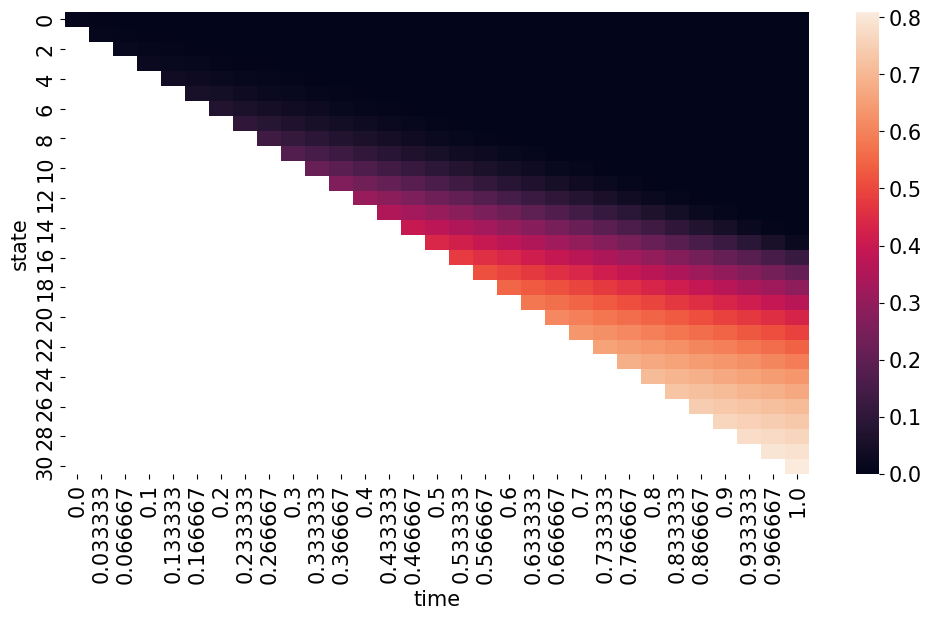

In [120]:
sns.heatmap(derivtree)

# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

5.1 Put on bond

In [121]:
STRIKE = 99
payoff = lambda p: np.maximum(STRIKE-p,0)

derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars, style = 'american')
format_bintree(derivtree, style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


### 5.2

Assuming the same dense rate tree and bond tree as in 4.4

In [123]:
pstars = pd.Series(pstar, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
pstar,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%


Obtaining bond tree

In [124]:
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,96.1700,96.0842,95.9985,95.9129,95.8278,95.7433,95.6598,95.5773,95.4962,95.4169,95.3396,95.2647,95.1925,95.1235,95.0582,94.9969,94.9403,94.8889,94.8432,94.8039,94.7718,94.7475,94.7319,94.7258,94.7303,94.7462,94.7747,94.8169,94.8741,94.9477,95.0391,95.1498,95.2817,95.4365,95.6162,95.8229,96.0590,96.3270,96.6296,96.9697,97.3506,97.7758,98.2489,98.7743,99.3563
1,,96.4829,96.4058,96.3288,96.2521,96.1761,96.1008,96.0266,95.9536,95.8821,95.8125,95.7450,95.6800,95.6179,95.5590,95.5038,95.4528,95.4065,95.3653,95.3299,95.3010,95.2791,95.2651,95.2596,95.2636,95.2780,95.3037,95.3417,95.3933,95.4596,95.5420,95.6418,95.7606,95.9000,96.0619,96.2480,96.4606,96.7017,96.9739,97.2798,97.6222,98.0042,98.4292,98.9008,99.4229
2,,,96.7723,96.7030,96.6341,96.5657,96.4979,96.4311,96.3654,96.3011,96.2384,96.1777,96.1192,96.0632,96.0102,95.9605,95.9146,95.8728,95.8358,95.8039,95.7778,95.7582,95.7455,95.7406,95.7442,95.7572,95.7803,95.8146,95.8611,95.9208,95.9950,96.0849,96.1919,96.3174,96.4631,96.6306,96.8219,97.0388,97.2836,97.5586,97.8663,98.2094,98.5910,99.0143,99.4826
3,,,,97.0398,96.9778,96.9162,96.8553,96.7952,96.7361,96.6782,96.6218,96.5671,96.5145,96.4641,96.4164,96.3717,96.3304,96.2928,96.2594,96.2308,96.2073,96.1896,96.1782,96.1738,96.1771,96.1887,96.2096,96.2405,96.2823,96.3361,96.4029,96.4838,96.5801,96.6931,96.8241,96.9748,97.1468,97.3419,97.5619,97.8091,98.0855,98.3937,98.7363,99.1161,99.5362
4,,,,,97.2869,97.2315,97.1767,97.1227,97.0695,97.0175,96.9668,96.9176,96.8702,96.8249,96.7820,96.7418,96.7046,96.6708,96.6408,96.6150,96.5939,96.5779,96.5677,96.5638,96.5667,96.5772,96.5960,96.6238,96.6615,96.7099,96.7700,96.8428,96.9294,97.0310,97.1489,97.2844,97.4390,97.6144,97.8121,98.0341,98.2824,98.5592,98.8667,99.2074,99.5842
5,,,,,,97.5150,97.4658,97.4172,97.3694,97.3226,97.2770,97.2328,97.1902,97.1495,97.1109,97.0747,97.0413,97.0109,96.9839,96.9607,96.9417,96.9274,96.9182,96.9146,96.9173,96.9267,96.9436,96.9687,97.0025,97.0461,97.1001,97.1656,97.2435,97.3349,97.4408,97.5627,97.7016,97.8592,98.0369,98.2363,98.4593,98.7077,98.9836,99.2894,99.6273
6,,,,,,,97.7256,97.6819,97.6390,97.5969,97.5559,97.5162,97.4779,97.4413,97.4066,97.3741,97.3440,97.3167,97.2924,97.2716,97.2545,97.2416,97.2334,97.2302,97.2326,97.2411,97.2563,97.2788,97.3093,97.3484,97.3970,97.4559,97.5259,97.6080,97.7033,97.8127,97.9376,98.0792,98.2387,98.4178,98.6180,98.8410,99.0886,99.3629,99.6659
7,,,,,,,,97.9198,97.8812,97.8435,97.8066,97.7709,97.7365,97.7036,97.6725,97.6432,97.6162,97.5916,97.5698,97.5511,97.5358,97.5242,97.5168,97.5139,97.5161,97.5237,97.5374,97.5576,97.5850,97.6202,97.6639,97.7168,97.7797,97.8535,97.9391,98.0374,98.1496,98.2767,98.4200,98.5808,98.7605,98.9606,99.1828,99.4288,99.7005
8,,,,,,,,,98.0989,98.0650,98.0319,97.9998,97.9689,97.9393,97.9113,97.8851,97.8608,97.8387,97.8191,97.8023,97.7885,97.7781,97.7715,97.7689,97.7708,97.7777,97.7900,97.8082,97.8328,97.8644,97.9037,97.9512,98.0077,98.0740,98.1509,98.2392,98.3400,98.4541,98.5828,98.7271,98.8884,99.0680,99.2673,99.4879,99.7315


Price the derivative

In [125]:
STRIKE = 99
EXPIRATION = 1

payoff = lambda p: np.maximum(STRIKE -p,0)

ratetreeT = ratetree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')
bondtreeT = bondtree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')

derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars, style = 'american')
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.8300,2.9158,3.0015,3.0871,3.1722,3.2567,3.3402,3.4227,3.5038,3.5831,3.6604,3.7353,3.8075,3.8765,3.9418,4.0031,4.0597,4.1111,4.1568,4.1961,4.2282,4.2525,4.2681,4.2742,4.2697,4.2538,4.2253,4.1831,4.1259,4.0523,3.9609
1,,2.5171,2.5942,2.6712,2.7479,2.8239,2.8992,2.9734,3.0464,3.1179,3.1875,3.2550,3.3200,3.3821,3.4410,3.4962,3.5472,3.5935,3.6347,3.6701,3.6990,3.7209,3.7349,3.7404,3.7364,3.7220,3.6963,3.6583,3.6067,3.5404,3.4580
2,,,2.2277,2.2970,2.3659,2.4343,2.5021,2.5689,2.6346,2.6989,2.7616,2.8223,2.8808,2.9368,2.9898,3.0395,3.0854,3.1272,3.1642,3.1961,3.2222,3.2418,3.2545,3.2594,3.2558,3.2428,3.2197,3.1854,3.1389,3.0792,3.0050
3,,,,1.9602,2.0222,2.0838,2.1447,2.2048,2.2639,2.3218,2.3782,2.4329,2.4855,2.5359,2.5836,2.6283,2.6696,2.7072,2.7406,2.7692,2.7927,2.8104,2.8218,2.8262,2.8229,2.8113,2.7904,2.7595,2.7177,2.6639,2.5971
4,,,,,1.7131,1.7685,1.8233,1.8773,1.9305,1.9825,2.0332,2.0824,2.1298,2.1751,2.2180,2.2582,2.2954,2.3292,2.3592,2.3850,2.4061,2.4221,2.4323,2.4362,2.4333,2.4228,2.4040,2.3762,2.3385,2.2901,2.2300
5,,,,,,1.4850,1.5342,1.5828,1.6306,1.6774,1.7230,1.7672,1.8098,1.8505,1.8891,1.9253,1.9587,1.9891,2.0161,2.0393,2.0583,2.0726,2.0818,2.0854,2.0827,2.0733,2.0564,2.0313,1.9975,1.9539,1.8999
6,,,,,,,1.2744,1.3181,1.3610,1.4031,1.4441,1.4838,1.5221,1.5587,1.5934,1.6259,1.6560,1.6833,1.7076,1.7284,1.7455,1.7584,1.7666,1.7698,1.7674,1.7589,1.7437,1.7212,1.6907,1.6516,1.6030
7,,,,,,,,1.0802,1.1188,1.1565,1.1934,1.2291,1.2635,1.2964,1.3275,1.3568,1.3838,1.4084,1.4302,1.4489,1.4642,1.4758,1.4832,1.4861,1.4839,1.4763,1.4626,1.4424,1.4150,1.3798,1.3361
8,,,,,,,,,0.9011,0.9350,0.9681,1.0002,1.0311,1.0607,1.0887,1.1149,1.1392,1.1613,1.1809,1.1977,1.2115,1.2219,1.2285,1.2311,1.2292,1.2223,1.2100,1.1918,1.1672,1.1356,1.0963


Here we get price of the option at t=0 as 2.83 which is relatively closer to the two period estimation seen in 5.1. One reason for the difference is that impact from parameterization is lesser in the this given this is a put option.

<Axes: xlabel='time', ylabel='state'>

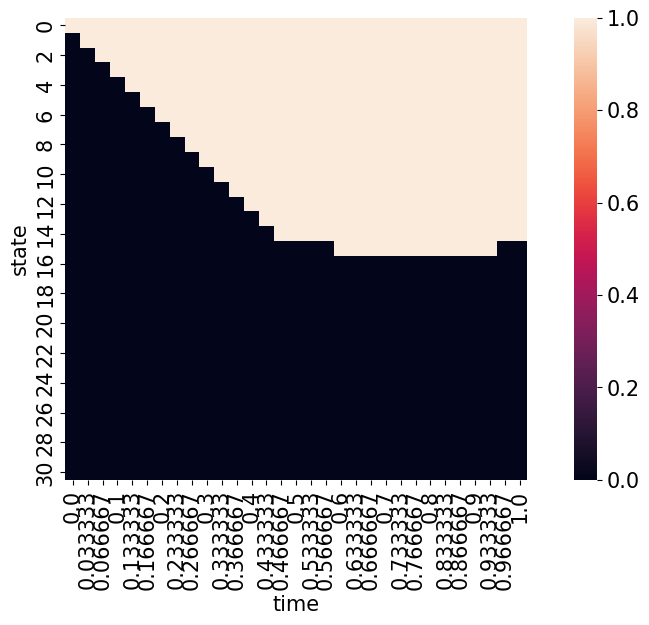

In [126]:
sns.heatmap(exercise_decisions(payoff, undertree=bondtreeT, derivtree=derivtree),square=True)